In [31]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2, Compose
from torchvision.io import decode_image
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [32]:
# PREPROCESSING

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch_generator1 = torch.Generator().manual_seed(42)
torch_generator2 = torch.Generator().manual_seed(43)

# 1. Load the Dataset

temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../data/vehicle-type-detection' # Assuming you run the script from the parent directory
full_dataset_temp = datasets.ImageFolder(data_dir, transform=temp_transform)

# 2. Split the Data
train_size = int(0.8 * len(full_dataset_temp))
val_size = len(full_dataset_temp) - train_size
train_dataset_temp, val_dataset_temp = random_split(full_dataset_temp, [train_size, val_size], generator=torch_generator1)


# 3. Calculate Mean and STD on train data
TEMP_BATCH_SIZE = 64
temp_train_loader = DataLoader(train_dataset_temp, batch_size=TEMP_BATCH_SIZE, shuffle=False)

def calculate_mean_and_std(loader):
    """Calculates channel-wise mean and standard deviation from a DataLoader."""
    channels_sum, channels_sq_sum, num_batches = 0, 0, 0

    # Iterate over the dataset and accumulate sums
    for data, _ in tqdm(loader, desc="Calculating Stats"):
        # data shape is (batch_size, channels, height, width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Final calculation
    mean = channels_sum / num_batches
    # E[(X - mu)^2] = E[X^2] - (E[X])^2
    std = torch.sqrt(channels_sq_sum / num_batches - mean**2)

    # Convert tensors to lists/tuples of floats for use in transforms.Normalize
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_and_std(temp_train_loader)

# 4. Define Preprocessing Pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),     # Crop to 224x224 (standard input size for many CNNs)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),          # Converts image to a PyTorch Tensor and scales to [0, 1]
    transforms.Normalize(mean=MEAN, std=STD) # Apply normalization
])

full_dataset_transformed = datasets.ImageFolder(data_dir, transform=transform)

# Retain the original indices from the first random_split
# train_dataset and val_dataset are Subsets, we get their indices:
train_indices = train_dataset_temp.indices
val_indices = val_dataset_temp.indices

# Create the final, fully transformed train and validation datasets
# We use the original indices on the new fully-transformed dataset
train_dataset= Subset(full_dataset_transformed, train_indices)
val_test_dataset = Subset(full_dataset_transformed, val_indices)
val_dataset, test_dataset = random_split(val_test_dataset, [val_size // 2, val_size-val_size//2], torch_generator2)

# Check sizes to ensure split is preserved
print(f"Final Train Size: {len(train_dataset)}")
print(f"Final Validation Size: {len(val_dataset)}")

# 4. Create DataLoaders
# DataLoader handles batching, shuffling, and multi-threaded loading
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Calculating Stats:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating Stats: 100%|██████████| 17/17 [00:03<00:00,  4.94it/s]

Final Train Size: 1048
Final Validation Size: 131


In [ ]:
print(type(train_loader))
print(len(train_loader))
for inputs, labels in train_loader:
    print(inputs.shape, labels.shape)


In [34]:
class CNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        # Convolution + pooling
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)    # 1 kanal inn -> 6 feature maps
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)   # 6 -> 16 feature maps

        # Finn riktig flatten-størrelse automatisk
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)        # batch=1, 1 kanal, 224x224
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            flatten_size = x.view(1, -1).shape[1]

        # Fully connected-lag
        self.fc1 = nn.Linear(flatten_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)      # (batch, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)              # logits
        return x

cnn = CNN(6)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


num_epochs = 5

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):

    ### -------- TRAIN -------- ###
    cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    ### -------- VALIDATION -------- ###
    cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = cnn(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    epoch_val_loss = val_loss / val_total
    epoch_val_acc = val_correct / val_total

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {epoch_train_loss:.4f}, acc: {epoch_train_acc:.4f} | "
          f"Val loss: {epoch_val_loss:.4f}, acc: {epoch_val_acc:.4f}")


Using device: cpu
Epoch 1/5 | Train loss: 0.6268, acc: 0.7462 | Val loss: 0.5533, acc: 0.7939
Epoch 2/5 | Train loss: 0.5920, acc: 0.7700 | Val loss: 0.5072, acc: 0.7786
Epoch 3/5 | Train loss: 0.5908, acc: 0.7853 | Val loss: 0.6758, acc: 0.7634
Epoch 4/5 | Train loss: 0.6239, acc: 0.7538 | Val loss: 0.5859, acc: 0.7863
Epoch 5/5 | Train loss: 0.5510, acc: 0.7834 | Val loss: 0.4363, acc: 0.8092


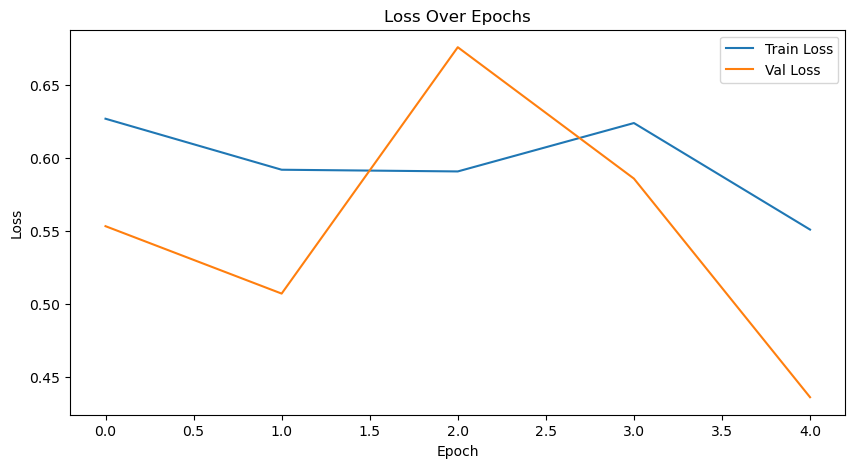

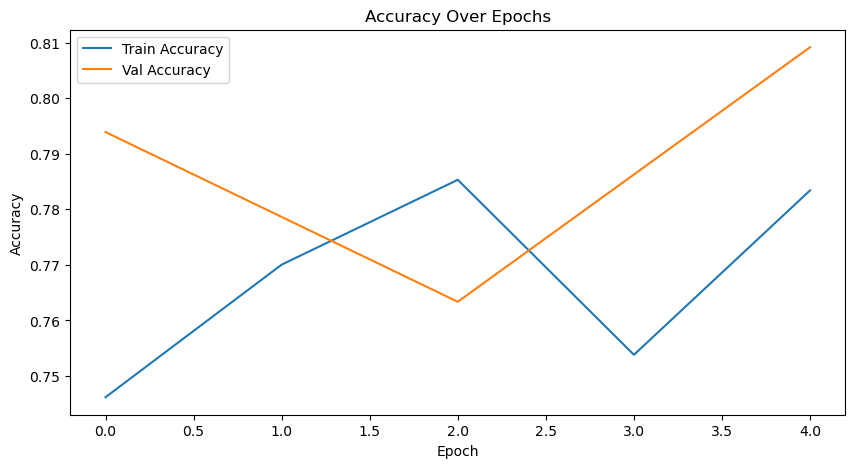

In [39]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the val images: {100 * correct // total} %')